In [1]:
# Gun Control Laws
# Related to the previous gun control post,
# this visualization shows the level of gun
# control legislature in various United States.
# Matt Spencer - DataBard
# www.databard.blog
# 4/9/2018
library(dplyr)
library(tidyr)
library(ggplot2)
library(fiftystater)
library(maps)
library(RColorBrewer)
library(gtable)
library(grid)
library(gridExtra)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine



In [2]:
theme_Publication <- function(base_size=14, base_family="helvetica") {
      library(grid)
      library(ggthemes)
      (theme_foundation(base_size=base_size, base_family=base_family)
       + theme(plot.title = element_text(face = "bold",
                                         size = rel(1.2), hjust = 0.5),
               text = element_text(),
               panel.background = element_rect(colour = NA),
               plot.background = element_rect(colour = NA),
               panel.border = element_rect(colour = NA),
               axis.title = element_text(face = "bold",size = rel(1)),
               axis.title.y = element_text(angle=90,vjust =2),
               axis.title.x = element_text(vjust = -0.2),
               axis.text = element_text(), 
               axis.line = element_line(colour="black"),
               axis.ticks = element_line(),
               panel.grid.major = element_line(colour="#f0f0f0"),
               panel.grid.minor = element_line(colour="#f0f0f0"),
               #legend.key = element_rect(colour = NA),
               #legend.position = "bottom",
               #legend.direction = "horizontal",
               #legend.key.size= unit(0.2, "cm"),
               #legend.margin = unit(0, "cm"),
               #legend.title = element_text(face="italic"),
               plot.margin=unit(c(10,5,5,5),"mm"),
               strip.background=element_rect(colour="#f0f0f0",fill="#f0f0f0"),
               strip.text = element_text(face="bold")
          ))
      
}

scale_fill_Publication <- function(...){
      library(scales)
      discrete_scale("fill","Publication",manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33")), ...)

}

scale_colour_Publication <- function(...){
      library(scales)
      discrete_scale("colour","Publication",manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33")), ...)

}

# Function to generate the copyright for any plot
# Useage:
# g <- ggplot(...) + ...
# add.copyright(g)
# add.copyright(g, 0.5, 1/20)
add.copyright <- function(plot, fontsize=1, rel.height=1/20) {
    library(grid)
    library(gridExtra)
    cp <- textGrob(paste("\uA9 Matt Spencer ", format(Sys.time(), "%Y"), ", databard.blog", sep=''),
             gp=gpar(fontfamily = "Verdana", cex=fontsize) ,
             x=unit(1, "npc"), hjust = 1) #, y=unit(0, "npc"), vjust = 0)
    
    cp.h <- round(rel.height*100)
    plot.h <- 100-cp.h
    lay <- matrix(c(rep(1,plot.h), rep(2,cp.h)))
    
    return(grid.arrange(plot, cp, layout_matrix = lay))
}


In [3]:
# Data Loading and Prep for Viz 4
# Load data for gun restriction laws per state
restrictions <- read.csv("data/restrictions_state.csv", stringsAsFactors = F) %>% filter(!is.na(.[,2])) %>% select(-Brady.Rating)
colnames(restrictions) <- c("State", "Region", "Subregion", "Background Checks", "Full Discretion", "Screening for Purchase", 
                            "Identify Dangerous People", "Secure Undeserved Guns", "Prevent Sale to Criminals")

# Quick-adjust factors #
gap.size <- 5
alpha.scale.factor <- 2
# Quick-adjust factors #

all.prep <- restrictions %>% 
    gather(key = Category, value = Value, colnames(restrictions)[4:9]) %>%
    mutate(Category = factor(Category,
                             levels = c("Identify Dangerous People", "Secure Undeserved Guns", "Prevent Sale to Criminals",
                                        "Background Checks", "Full Discretion", "Screening for Purchase")),
           Region = factor(Region, levels = c("NE", "S", "MW", "W")), 
           Subregion = factor(Subregion, levels = c("New England", "Middle Atlantic", "South Atlantic", "East South Atlantic",
                                                    "East South Central", "West South Central", "East North Central", 
                                                    "West North Central", "Mountain", "Pacific")),
           y = as.numeric(Category) + gap.size) %>%
    mutate(Abb = state.abb[match(State, state.name)]) %>%
    arrange(Region, Subregion, Abb) %>%
    ungroup() %>%
    mutate(x = group_indices(., Region, Subregion, Abb)) 

state.abbs <- all.prep %>% select(State, Region, Subregion, Abb, x) %>% unique()

long.data <- all.prep %>%
    group_by(Category) %>%
    mutate(min = min(Value)) %>%
    filter(Value != min(Value)) %>%
    mutate(min = min(Value), max = max(Value), Norm = (Value - min) / max) %>%
    mutate(Norm = (Norm + alpha.scale.factor - 1) / alpha.scale.factor)

v4.colors <- c(brewer.pal(7, 'Dark2'))[c(6,5,4,3,2,1)]

Warning message:
"Ignoring unknown aesthetics: fill"Warning message:
"Ignoring unknown aesthetics: fill"

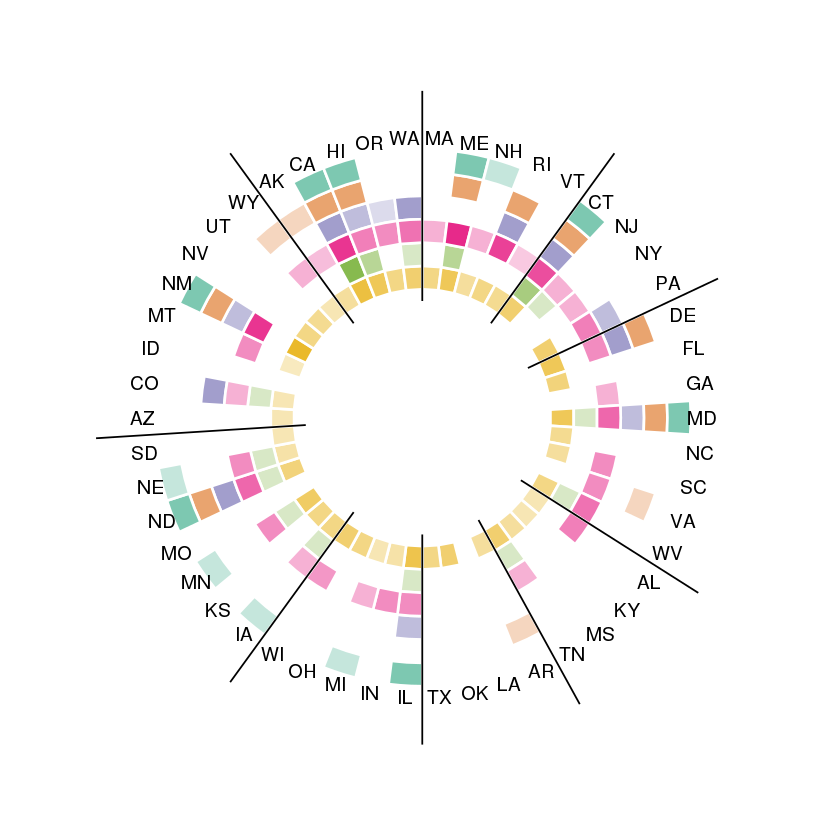

In [6]:
# Plotting Viz 4

# Plot-specific elements
ymin <- gap.size
num.ys <- length(levels(long.data$Category)) 
line.extension <- 3
ymax <- ymin + num.ys + line.extension

divisions <- long.data %>%
    group_by(Subregion) %>%
    summarize(max = max(x)) %>%
    mutate(x = max + 0.5, xend = max + 0.5, y = ymin, yend = ymax) 

# Plot it
v4.round <- ggplot(data = long.data, aes(x = x, y = y, fill = Category, alpha = Norm)) +
    geom_tile(color = "white", size = 0.75) +
    geom_text(data = state.abbs, aes(label = Abb, fill = NULL), y = ymin + num.ys + 1, alpha = 1, size = 4) +
    geom_segment(data = divisions, aes(x = x, xend = xend, y = y, yend = yend, fill = NULL, alpha = NULL)) +
    scale_y_continuous(limits = c(0, ymax)) +
    scale_alpha_continuous(range = c(0.25, 1)) +
    scale_fill_manual(values = v4.colors) +
    coord_polar("x") +
    guides(fill = F, alpha = F) +
    theme(
        panel.background = element_rect(fill = "white"),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.title.x = element_blank(),
        axis.title.y = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank()
    )
v4.round
#ggsave(file = 'figures/4.round.tiff', v4.round, width = 12, height = 12, dpi = 200)

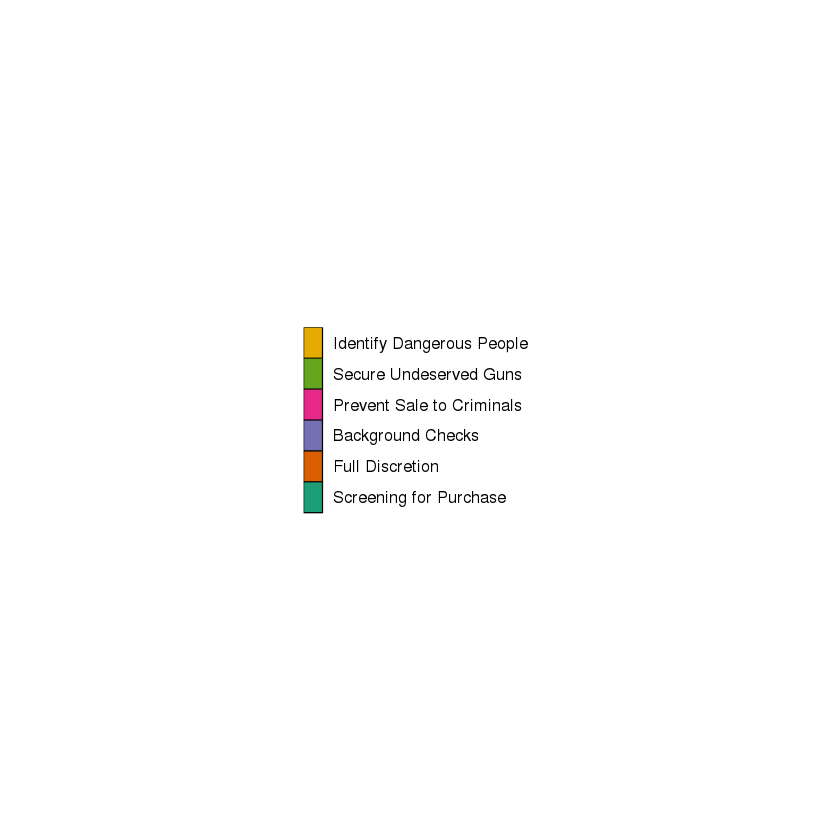

In [5]:
# Create a legend
find_cell <- function(table, row, col, name = "core-bg"){
  l <- table$layout
  which(l$t == row & l$l == col & l$name == name)
}
mintheme <- ttheme_minimal(
      core=list(fg_params = list(hjust = 0, x = 0.05, fontsize = 10)))

table.df <- data.frame(colors = rep('', 6), 
                       labels = c("Identify Dangerous People", "Secure Undeserved Guns", "Prevent Sale to Criminals",
                                      "Background Checks", "Full Discretion", "Screening for Purchase"))

table.colors <- v4.colors

t <- tableGrob(table.df, cols = NULL, rows = NULL, theme = mintheme)

for (i in 1:6) {
    cell <- find_cell(t, i, 1)
    t$grobs[cell][[1]][["gp"]] <- gpar(fill = table.colors[i], col = "black", lwd = 1)
}

round.legend <- t
grid.draw(round.legend)
#ggsave(file = 'figures/4.legend.tiff', round.legend, width = 3, height = 6, dpi = 300)

In [11]:
# Draw states by region
data("fifty_states")
regions <- state.abbs %>% select(State, Subregion) %>%
    mutate(State = tolower(State)) %>% merge(fifty_states, by.x="State", by.y="id") %>%
    mutate(x=long, y=lat, id=State) %>%
    group_by(group) %>%
    arrange(order)

for (roi in unique(regions$Subregion)) {
    this.region <- regions %>% filter(Subregion == roi)

    filename <- paste("figures/", gsub(' ', '', roi), ".tiff", sep='')
    
    small.map <- ggplot(data=this.region, aes(x, y, map_id=id)) + 
        geom_map(map=this.region, color="black", fill="white", size=0.25) + 
        coord_map("albers", lat0=30, lat1=40, 
                  xlim = c(-130, -60), ylim = c(20, 50)) + 
        theme_void() 
    #ggsave(file=filename, small.map, width = 12, height = 12, dpi=300)
}

Warning message:
"Unknown or uninitialised column: 'region'."Warning message:
"Unknown or uninitialised column: 'region'."Warning message:
"Unknown or uninitialised column: 'region'."Warning message:
"Unknown or uninitialised column: 'region'."Warning message:
"Unknown or uninitialised column: 'region'."Warning message:
"Unknown or uninitialised column: 'region'."Warning message:
"Unknown or uninitialised column: 'region'."Warning message:
"Unknown or uninitialised column: 'region'."Warning message:
"Unknown or uninitialised column: 'region'."